# Denoising Diffusion Probabilistic Model




#### 1.   Please note that this assignment requires a functional GPU. If your computer does not have a GPU, please use GOOGLE Colab [https://colab.research.google.com/](https://colab.research.google.com/) which will provide free GPU/TPU.
#### 2.   In order to use GOOGLE Colab, all you need to do is：
##### Step 1: Go to Google Colab website on the browser of your choice and click on the “Open Colab” option on the right-hand side top menu bar. This will open up a google colab notebook.
##### Step 2: sign in into your google account.
##### Step 3: Click on “upload” in the bottom menu bar to upload your assignment.
##### Step 4: In order to connect to GPU, click on the small down arrow icon, just besides the **Connect button**, go to “**Change runtime type**” option.
##### Step 5: In the dialog box, select the “T4 GPU” radio button, and then click on “Save” button. This will reinitialize a session for us, but, now with GPU computational resources.


#### **Important! Try the following things in case your training epoch takes too long:**

1. **Reduce the size of the training data**, you may limit your training samples to those only containing digits 1, 2 and 3 in the MNIST data set.

2. **Smaller number of epochs**, you can decrease the total number of epochs from 200 to 100.

3. **Reducing the T-value**, reduce timestep from 1000 to 500.

*The last two approaches may significantly reduce generation quality, so proceed with caution!*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

## Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.80MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


#### you can use following cell to select only samples 1, 2 and 3.

In [4]:
# 减少训练数据量

from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
full_test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

# only 1、2 and 3 sample
selected_train_indices = [idx for idx, (image, label) in enumerate(full_train_dataset) if label in [1, 2, 3]]
selected_test_indices = [idx for idx, (image, label) in enumerate(full_test_dataset) if label in [1, 2, 3]]

train_dataset = Subset(full_train_dataset, selected_train_indices)
test_dataset = Subset(full_test_dataset, selected_test_indices)


train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)



## Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs)

Sinusoidal embedding for diffusion timestep

In [5]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture.

In [6]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):

        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y

In [7]:
DEVICE = torch.device("cuda:0" if cuda else "cpu")

In [8]:
class Denoiser(nn.Module):

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()

        _, _, img_C = image_resolution

        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)

        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        self.time_project = nn.Sequential(
                          ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                          ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1)
                          )

        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                     activation_fn=True, gn=True, gn_groups=8)
                    )

        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)


    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x

        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        y = self.in_project(y)

        for i in range(len(self.convs)):
            ##########################################################
            ## Fill in the code here##################################
            y = self.convs[i](y, diffusion_embedding, residual=True if i > 0 else False)
            ########the end###########################################

        y = self.out_project(y)

        return y

    def save_weights(self, file_path):
        """
        """
        torch.save(self.state_dict(), file_path)


model = Denoiser(image_resolution = img_size,
          hidden_dims = hidden_dims,
          diffusion_time_embedding_dim = timestep_embedding_dim,
          n_times = n_timesteps).to(DEVICE)

file_path = "/content/model_weights.pth"
model.save_weights(file_path)
print("saved to:", file_path)

saved to: /content/model_weights.pth


### Define Gaussian Diffusion

In [9]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=100, beta_minmax=[1e-4, 2e-2], device='cuda'):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model

        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)

        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        ##########################################################
        ## Fill in the code here##################################
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        ########the end###########################################

        self.device = device

    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        ##########################################################
        ## Fill in the code here##################################
        noisy_sample = sqrt_alpha_bar * x_zeros + sqrt_one_minus_alpha_bar * epsilon
        ########the end###########################################

        return noisy_sample.detach(), epsilon


    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon


    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # denoise at time t, utilizing predicted noise
        ##########################################################
        ## Fill in the code here##################################
        x_t_minus_1 = (x_t - ((1 - alpha) / sqrt_one_minus_alpha_bar) * epsilon_pred) / sqrt_alpha + sqrt_beta * z
        ########the end###########################################

        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)

        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0


diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps,
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


### Visualizing forward process

In [11]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [12]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

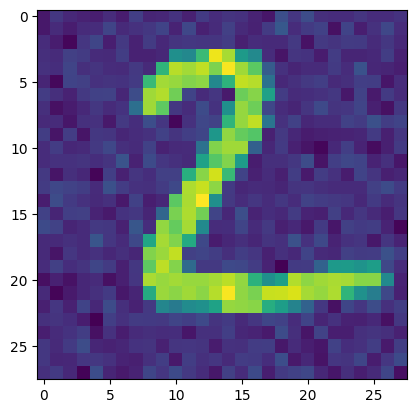

In [26]:
show_image(perturbed_images, idx=0)

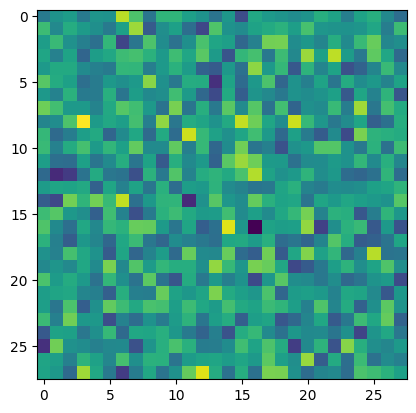

In [27]:
show_image(perturbed_images, idx=1)

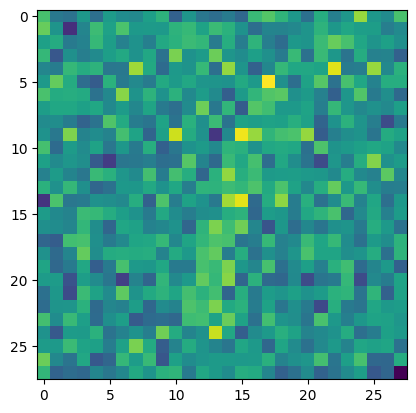

In [28]:
show_image(perturbed_images, idx=2)

## Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs)

注：试图跑完来着，但跑一半gpu免费额度没了。。。



In [ ]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)

        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)

    if (epoch + 1) >= 50 and (epoch + 1) % 5 == 0:
        file_path = f"/content/model_weights_epoch_{epoch + 1}.pth"
        model.save_weights(file_path)
        print("Model weights for epoch", epoch + 1, "saved to:", file_path)

print("Finish!!")

Start training DDPMs...


100%|██████████| 148/148 [01:43<00:00,  1.43it/s]

	Epoch 1 complete! 	Denoising Loss:  0.23549610274989588



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 2 complete! 	Denoising Loss:  0.09891764322916667



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 3 complete! 	Denoising Loss:  0.07701607469190545



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 4 complete! 	Denoising Loss:  0.06785849524902648



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 5 complete! 	Denoising Loss:  0.06489224192135189



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 6 complete! 	Denoising Loss:  0.05910504485170046



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 7 complete! 	Denoising Loss:  0.058539027842331906



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 8 complete! 	Denoising Loss:  0.056964698570723435



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 9 complete! 	Denoising Loss:  0.05574909546951048



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 10 complete! 	Denoising Loss:  0.05461767787227825



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 11 complete! 	Denoising Loss:  0.053022005221470686



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 12 complete! 	Denoising Loss:  0.05180847371111111



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 13 complete! 	Denoising Loss:  0.051534898198988974



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 14 complete! 	Denoising Loss:  0.051719600195381916



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 15 complete! 	Denoising Loss:  0.05064169968776151



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 16 complete! 	Denoising Loss:  0.04980255019705312



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 17 complete! 	Denoising Loss:  0.04984821546442655



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 18 complete! 	Denoising Loss:  0.04856721065989157



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 19 complete! 	Denoising Loss:  0.048635006077638286



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 20 complete! 	Denoising Loss:  0.04819445337365274



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 21 complete! 	Denoising Loss:  0.04936680126757849



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 22 complete! 	Denoising Loss:  0.04788041368228237



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 23 complete! 	Denoising Loss:  0.047648408887337665



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 24 complete! 	Denoising Loss:  0.046571063853445505



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 25 complete! 	Denoising Loss:  0.0472693856121326



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 26 complete! 	Denoising Loss:  0.048318590664741944



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 27 complete! 	Denoising Loss:  0.0474160753545307



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 28 complete! 	Denoising Loss:  0.04665183445730177



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 29 complete! 	Denoising Loss:  0.04598574157880277



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 30 complete! 	Denoising Loss:  0.046632087124245505



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 31 complete! 	Denoising Loss:  0.045938954694944176



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 32 complete! 	Denoising Loss:  0.04497610042695285



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 33 complete! 	Denoising Loss:  0.04555377468061285



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 34 complete! 	Denoising Loss:  0.04598945186657159



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 35 complete! 	Denoising Loss:  0.04413538745471409



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 36 complete! 	Denoising Loss:  0.04487265324612864



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 37 complete! 	Denoising Loss:  0.04530693180098826



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 38 complete! 	Denoising Loss:  0.04459982664406705



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 39 complete! 	Denoising Loss:  0.04476835910661691



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 40 complete! 	Denoising Loss:  0.044319647940851394



100%|██████████| 148/148 [01:42<00:00,  1.44it/s]

	Epoch 41 complete! 	Denoising Loss:  0.04437488512623878



100%|██████████| 148/148 [01:42<00:00,  1.45it/s]

	Epoch 42 complete! 	Denoising Loss:  0.04456926080189189



 31%|███       | 46/148 [00:31<01:10,  1.44it/s]

## Step 4. Sample images from noise.

In [ ]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

In [ ]:
show_image(generated_images, idx=0)

In [ ]:
show_image(generated_images, idx=1)

In [ ]:
show_image(generated_images, idx=2)

In [ ]:
show_image(generated_images, idx=3)

In [ ]:
show_image(generated_images, idx=4)

In [ ]:
show_image(generated_images, idx=5)

### Comparison with ground-truth samples

In [ ]:
def draw_sample_image(x, postfix):

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [ ]:
draw_sample_image(perturbed_images, "Perturbed Images")

In [ ]:
draw_sample_image(generated_images, "Generated Images")

In [ ]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")